W tym .ipynb chciałbym przedstawić moją szczątkową ideę sprawienia by w LogExpSketchu można było liczyć Jaccard Similarity

# Metoda na Jaccard Similarity w dowolnym szkicu danych
## co chcemy zrobić: 
Załóżmy że mamy dwa Multisety $\mathfrak{M}_1 = (\mathbb{S}_1, \mu_1), \mathfrak{M}_2 = (\mathbb{S}_2, \mu_2)$

Mamy też funkcję wag: $\lambda$

Chcemy policzyć Jaccard Similarity

$$J_w(A,B) := \frac{|A \cap B|_w}{|A \cup B|_w}$$

W ExpSketchu i pochodnych robimy to poprzez $$J_w(A,B) = Pr(A_k = B_k)$$

Mam zastrzeżenia do dowodu tego twierdzenia w którym jest użyte: "Apart from the negligible collisions" by uprościć zdecydowanie obliczenia.

## Metoda
Używamy **LogExpSketch**. Pamiętamy obok szkicu dodatkowy wiersz, w którym przechowujemy element pierwotny ze zbioru, który jest reprezentowany pod tym indeksem.

Niech $h_b$ - funkcja hashująca dająca na wyjście $b$ bitów, a $S$ - LogExpSketch

Tworzymy strukturę $D = (H, S)$, i podczas tworzenia szkicu, $S_i$ ma reprezentować element $x$, to my zapisujemy dodatkowo $H_i := h(x)$ 

Mogę też $S$ - ExpSketch do testów samej estymacji.

Pytanie, ile bitowa musi być funkcja $h$? Czy to nie zepsuje całej idei zmniejszania pamięci?

In [ ]:
import numpy as np
import mmh3
import math

CONST_2_TO_32=2**32
def hash_integer(x: str, seed: int, amount_bytes: int = 32) -> int:
    return mmh3.hash(x, seed, signed=False) % (2 ** amount_bytes)

def hash_unit(x: str, seed: int) -> float:
    hash = mmh3.hash(x, seed=seed, signed=False)
    return hash / CONST_2_TO_32

rng = np.random.default_rng()

def generate_seeds(m: int) -> list[int]:
    return rng.integers(10,1000000, size=m).tolist() # type: ignore

class ExpSketch:
    def __init__(self, m: int, b: int, seeds: list[int] | None = None):
        self.m = m
        self.b = b
        if seeds == None:
            self.seeds = generate_seeds(m)
        else:
            self.seeds = seeds

        self.M = np.array([np.inf for _ in range(m)])
        self.H = np.zeros(shape=m, dtype=np.int32)
    
    def add(self, x: str, weight: float = 1):
        u = np.fromiter((hash_unit(x, s) for s in self.seeds),dtype=np.float64, count=self.m)
        g = -np.log(u) / weight
        mask = g < self.M
        self.M[mask] = g[mask]
        for i, val in enumerate(mask):
            if val:
                self.H[i] = hash_integer(x, self.seeds[i], self.b)


    def estimate(self) -> float:
        return (self.m - 1.0) / self.M.sum()

    def jaccard_struct(self, other):
        return (self.M == other.M).sum() / self.m

    def jaccard_fp(self, other):
        return (self.H == other.H).sum() / self.m


class LogExpSketch:
    def __init__(self,
                 k: float,
                 m: int,
                 bits_per_field: int,
                 fingerprint_size: int,
                 seeds: list[int]) -> None:
        self.k   = k                       # podstawa logarytmu
        self.m   = m                       # liczba pól
        self.b   = fingerprint_size        # bity na fingerprint
        self.seeds = seeds                 # ziarna hashy

        self.r_min = -(1 << (bits_per_field - 1))
        self.r_max =  (1 << (bits_per_field - 1)) - 1

        self.M = np.full(m, self.r_min, dtype=np.int32)
        self.H = np.zeros(m,       dtype=np.uint32)

    # ------------------------------------------------------------
    def add(self, x: str, weight: float = 1.0):
        u = np.fromiter((hash_unit(x, s) for s in self.seeds),
                        dtype=np.float64, count=self.m)

        e = -np.log(u) / weight
        q = np.floor(-np.log(e) / np.log(self.k)).astype(np.int32)  # wektor Q
        q_clipped = np.minimum(q, self.r_max)                       # saturacja

        mask = q_clipped > self.M                                   # gdzie rośnie?
        self.M[mask] = q_clipped[mask]

        for i, val in enumerate(mask):
            if val:
                self.H[i] = hash_integer(x, self.seeds[i], self.b)


    # ------------------------------------------------------------
    def estimate(self) -> float:
        denom = np.power(self.k, -self.M, dtype=np.float64).sum()
        return (self.k - 1.0) * (self.m - 1.0) / (math.log(self.k) * denom)

    # ------------------------------------------------------------
    # Jaccard z identycznym mechanizmem jak w ExpSketch
    def jaccard_struct(self, other: "LogExpSketch") -> float:
        return (self.M == other.M).sum() / self.m

    def jaccard_fp(self, other: "LogExpSketch") -> float:
        return (self.H == other.H).sum() / self.m


In [67]:
import matplotlib.pyplot as plt
def make_estimate_plot(b_vals, all_js, all_jf, est_s_mean, est_f_mean, sketch_name, trials, true_J, additional_title=""):
    plt.figure(figsize=(8,4.5))

    # chmury
    for x, js, jf in zip(b_vals, all_js, all_jf):
        plt.scatter(np.full(trials, x-0.08), js, marker="o",
                    color="tab:blue",  alpha=0.01, s=18)
        plt.scatter(np.full(trials, x+0.08), jf, marker="s",
                    color="tab:orange", alpha=0.01, s=18)

    # linie średnich ESTYMAT
    plt.plot(b_vals, est_s_mean, "o-", lw=2.2, color="tab:blue",
            label="Średnia est. (M-struktura)")
    plt.plot(b_vals, est_f_mean, "s-", lw=2.2, color="tab:orange",
            label="Średnia est. (H-fingerprint)")

    plt.axhline(true_J, color="gray", ls="--", lw=1.8, label="Prawdziwy J")

    plt.xlabel("Liczba bitów $b$", fontweight="bold")
    plt.ylabel("Estymata Jaccarda", fontweight="bold")
    plt.title(f"Rozkład estymat J w {sketch_name}\n{additional_title}", fontweight="bold", pad=12)
    plt.grid(ls="--", alpha=.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

def make_relative_error_plot(b_vals, all_err_s, all_err_f, trials, err_s_mean, err_f_mean, draw_mstructure: bool,sketch_name, additional_title=""):
    plt.figure(figsize=(8,4.5))

    for x, e_s, e_f in zip(b_vals, all_err_s, all_err_f):
        if draw_mstructure:
                plt.scatter(np.full(trials, x-0.12), e_s, marker="o",
                        color="tab:blue",  alpha=0.01, s=18)
        plt.scatter(np.full(trials, x+0.12), e_f, marker="s",
                    color="tab:orange", alpha=0.01, s=18)
    if draw_mstructure:
        plt.plot(b_vals, err_s_mean, "o-", lw=2.2, color="tab:blue",
                label="Średni błąd (M-struktura)")
    plt.plot(b_vals, err_f_mean, "s-", lw=2.2, color="tab:orange",
            label="Średni błąd (H-fingerprint)")

    plt.xlabel("Liczba bitów $b$", fontweight="bold")
    plt.ylabel("Względny błąd estymatora", fontweight="bold")
    plt.title(f"Rozkład błędów względnych J w {sketch_name}\n{additional_title}", fontweight="bold", pad=12)
    plt.grid(ls="--", alpha=.6)
    plt.legend(); plt.tight_layout(); plt.show()

In [50]:
import numpy as np, math

# --- parametry -----------------------------------------------------------
m, n, overlap = 200, 10_00, 250
true_J  = overlap / (2*n - overlap)
b_vals  = range(3, 10)
trials  = 1000
pool    = 2_000_000
rng     = np.random.default_rng()
k, bits_per_field = 2, 8

# --- pojemniki -----------------------------------------------------------
est_s_mean, est_f_mean = [], []
err_s_mean, err_f_mean = [], []

all_js, all_jf   = [], []   # chmura estymat
all_err_s, all_err_f = [], []   # chmura błędów względnych

for b in b_vals:
    js, jf   = [], []
    errs_s, errs_f = [], []

    for _ in range(trials):
        seeds = generate_seeds(m)
        A = LogExpSketch(k, m, bits_per_field, b, seeds)
        B = LogExpSketch(k, m, bits_per_field, b, seeds)

        shared  = rng.choice(pool, overlap,      False)
        uniq_a  = rng.choice(pool, n - overlap,  False)
        uniq_b  = rng.choice(pool, n - overlap,  False)

        stream_A = np.concatenate([shared, uniq_a])
        stream_B = np.concatenate([shared, uniq_b])
        rng.shuffle(stream_A); rng.shuffle(stream_B)

        for x in stream_A: A.add(f"s{x}" if x in shared else f"a{x}")
        for x in stream_B: B.add(f"s{x}" if x in shared else f"b{x}")

        est_s = A.jaccard_struct(B)
        est_f = A.jaccard_fp(B)

        js.append(est_s); jf.append(est_f)

        err_s = abs(est_s - true_J) / true_J
        err_f = abs(est_f - true_J) / true_J
        errs_s.append(err_s); errs_f.append(err_f)

    # --- odkładamy „chmury” ----------------------------------------------
    all_js.append(js);           all_jf.append(jf)
    all_err_s.append(errs_s);    all_err_f.append(errs_f)

    # --- średnie ---------------------------------------------------------
    est_s_mean.append(np.mean(js));  est_f_mean.append(np.mean(jf))
    err_s_mean.append(np.mean(errs_s)); err_f_mean.append(np.mean(errs_f))


/tmp/ipykernel_6399/4103805796.py:76: RuntimeWarning: divide by zero encountered in log
  e = -np.log(u) / weight
/tmp/ipykernel_6399/4103805796.py:77: RuntimeWarning: invalid value encountered in cast
  q = np.floor(-np.log(e) / np.log(self.k)).astype(np.int32)  # wektor Q


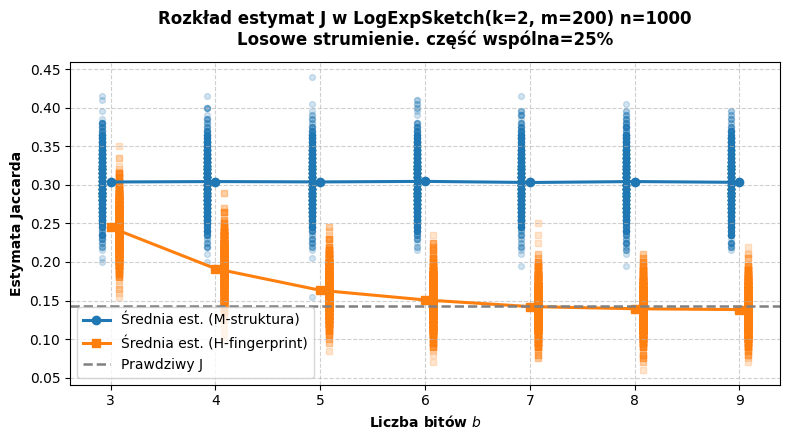

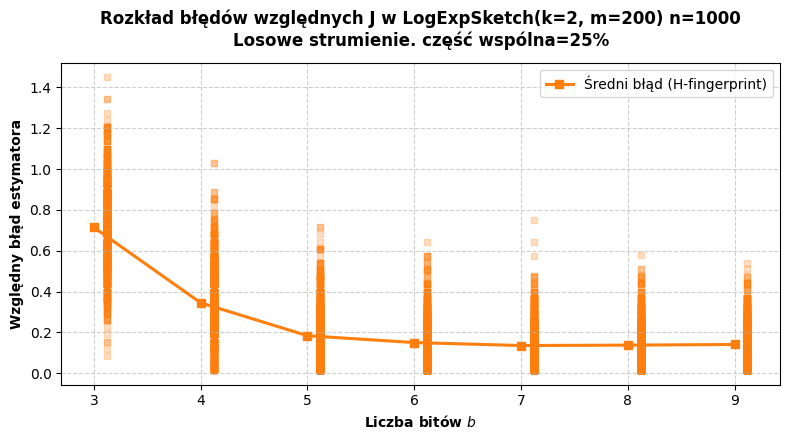

In [51]:
opis_testu="Losowe strumienie. część wspólna=25%"
make_estimate_plot(b_vals, all_js, all_jf, est_s_mean, est_f_mean, f"LogExpSketch(k={k}, m={m}) n={n}", trials, true_J, opis_testu)
make_relative_error_plot(b_vals, all_err_s, all_err_f, trials, err_s_mean, err_f_mean, False, f"LogExpSketch(k={k}, m={m}) n={n}", opis_testu)

In [52]:
import numpy as np, math

# --- parametry -----------------------------------------------------------
m, n, overlap = 200, 10_00, 250
true_J  = overlap / (2*n - overlap)
b_vals  = range(3, 10)
trials  = 1000
pool    = 2_000_000
rng     = np.random.default_rng()
k, bits_per_field = 2, 8

# --- pojemniki -----------------------------------------------------------
est_s_mean, est_f_mean = [], []
err_s_mean, err_f_mean = [], []

all_js, all_jf   = [], []   # chmura estymat
all_err_s, all_err_f = [], []   # chmura błędów względnych

for b in b_vals:
    js, jf   = [], []
    errs_s, errs_f = [], []

    for _ in range(trials):
        seeds = generate_seeds(m)
        A = LogExpSketch(k, m, bits_per_field, b, seeds)
        B = LogExpSketch(k, m, bits_per_field, b, seeds)

        shared  = rng.choice(pool, overlap,      False)
        uniq_a  = rng.choice(pool, n - overlap,  False)
        uniq_b  = rng.choice(pool, n - overlap,  False)

        stream_A = np.concatenate([shared, uniq_a])
        stream_B = np.concatenate([shared, uniq_b])
        # rng.shuffle(stream_A); rng.shuffle(stream_B)

        for x in stream_A: A.add(f"s{x}" if x in shared else f"a{x}")
        for x in stream_B: B.add(f"s{x}" if x in shared else f"b{x}")

        est_s = A.jaccard_struct(B)
        est_f = A.jaccard_fp(B)

        js.append(est_s); jf.append(est_f)

        err_s = abs(est_s - true_J) / true_J
        err_f = abs(est_f - true_J) / true_J
        errs_s.append(err_s); errs_f.append(err_f)

    # --- odkładamy „chmury” ----------------------------------------------
    all_js.append(js);           all_jf.append(jf)
    all_err_s.append(errs_s);    all_err_f.append(errs_f)

    # --- średnie ---------------------------------------------------------
    est_s_mean.append(np.mean(js));  est_f_mean.append(np.mean(jf))
    err_s_mean.append(np.mean(errs_s)); err_f_mean.append(np.mean(errs_f))


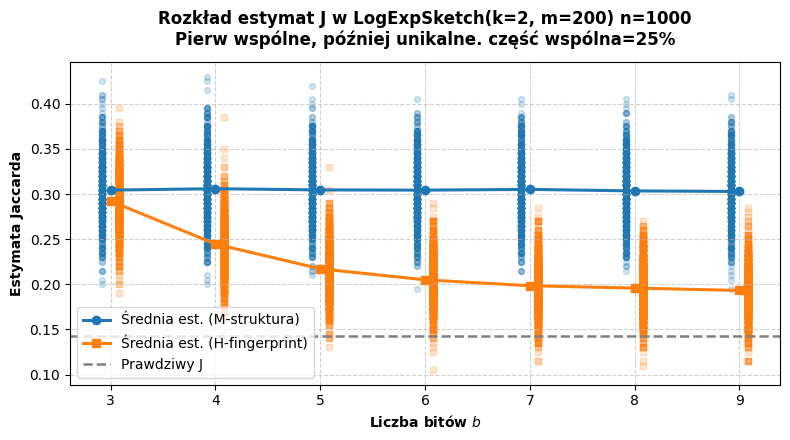

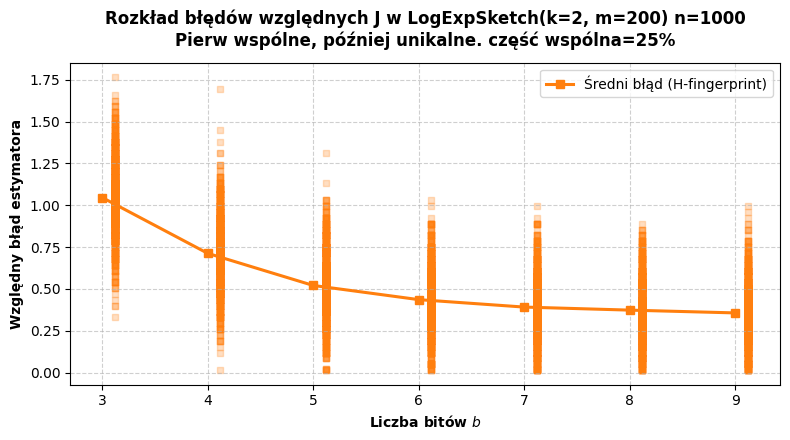

In [53]:
opis_testu="Pierw wspólne, później unikalne. część wspólna=25%"
make_estimate_plot(b_vals, all_js, all_jf, est_s_mean, est_f_mean, f"LogExpSketch(k={k}, m={m}) n={n}", trials, true_J, opis_testu)
make_relative_error_plot(b_vals, all_err_s, all_err_f, trials, err_s_mean, err_f_mean, False, f"LogExpSketch(k={k}, m={m}) n={n}", opis_testu)

In [69]:
import numpy as np, math

# --- parametry -----------------------------------------------------------
m, n, overlap = 200, 10_00, 250
true_J  = overlap / (2*n - overlap)
b_vals  = range(3, 10)
trials  = 1000
pool    = 2_000_000
rng     = np.random.default_rng()
k, bits_per_field = 2, 8

# --- pojemniki -----------------------------------------------------------
est_s_mean, est_f_mean = [], []
err_s_mean, err_f_mean = [], []

all_js, all_jf   = [], []   # chmura estymat
all_err_s, all_err_f = [], []   # chmura błędów względnych

for b in b_vals:
    js, jf   = [], []
    errs_s, errs_f = [], []

    for _ in range(trials):
        seeds = generate_seeds(m)
        A = LogExpSketch(k, m, bits_per_field, b, seeds)
        B = LogExpSketch(k, m, bits_per_field, b, seeds)

        shared  = rng.choice(pool, overlap,      False)
        uniq_a  = rng.choice(pool, n - overlap,  False)
        uniq_b  = rng.choice(pool, n - overlap,  False)

        stream_A = np.concatenate([uniq_a, shared])
        stream_B = np.concatenate([uniq_b, shared])
        # rng.shuffle(stream_A); rng.shuffle(stream_B)

        for x in stream_A: A.add(f"s{x}" if x in shared else f"a{x}")
        for x in stream_B: B.add(f"s{x}" if x in shared else f"b{x}")

        est_s = A.jaccard_struct(B)
        est_f = A.jaccard_fp(B)

        js.append(est_s); jf.append(est_f)

        err_s = abs(est_s - true_J) / true_J
        err_f = abs(est_f - true_J) / true_J
        errs_s.append(err_s); errs_f.append(err_f)

    # --- odkładamy „chmury” ----------------------------------------------
    all_js.append(js);           all_jf.append(jf)
    all_err_s.append(errs_s);    all_err_f.append(errs_f)

    # --- średnie ---------------------------------------------------------
    est_s_mean.append(np.mean(js));  est_f_mean.append(np.mean(jf))
    err_s_mean.append(np.mean(errs_s)); err_f_mean.append(np.mean(errs_f))


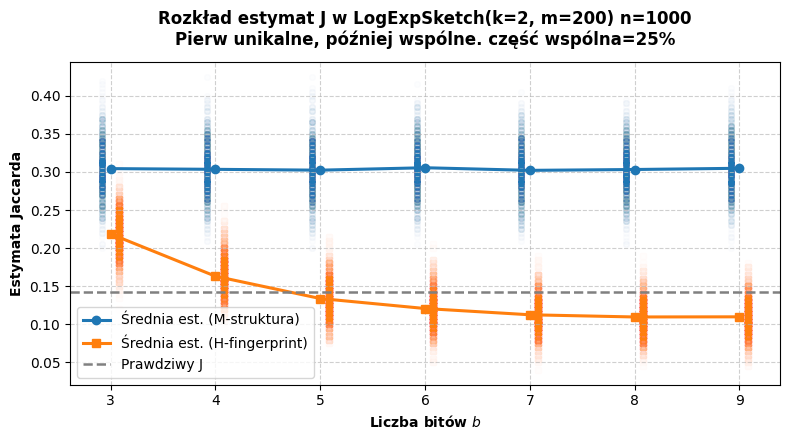

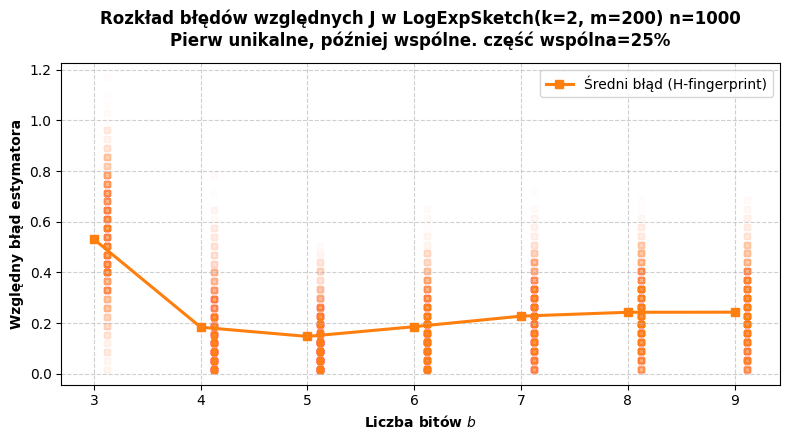

In [70]:
opis_testu="Pierw unikalne, później wspólne. część wspólna=25%"
make_estimate_plot(b_vals, all_js, all_jf, est_s_mean, est_f_mean, f"LogExpSketch(k={k}, m={m}) n={n}", trials, true_J, opis_testu)
make_relative_error_plot(b_vals, all_err_s, all_err_f, trials, err_s_mean, err_f_mean, False, f"LogExpSketch(k={k}, m={m}) n={n}", opis_testu)

In [56]:
import numpy as np, math

# --- parametry -----------------------------------------------------------
m, n, overlap = 100, 10_000, 2500
true_J  = overlap / (2*n - overlap)
b_vals  = range(3, 10)
trials  = 1000
pool    = 2_000_000
rng     = np.random.default_rng()
k, bits_per_field = 2, 8

# --- pojemniki -----------------------------------------------------------
est_s_mean, est_f_mean = [], []
err_s_mean, err_f_mean = [], []

all_js, all_jf   = [], []   # chmura estymat
all_err_s, all_err_f = [], []   # chmura błędów względnych

for b in b_vals:
    js, jf   = [], []
    errs_s, errs_f = [], []

    for _ in range(trials):
        seeds = generate_seeds(m)
        A = LogExpSketch(k, m, bits_per_field, b, seeds)
        B = LogExpSketch(k, m, bits_per_field, b, seeds)

        shared  = rng.choice(pool, overlap,      False)
        uniq_a  = rng.choice(pool, n - overlap,  False)
        uniq_b  = rng.choice(pool, n - overlap,  False)

        stream_A = np.concatenate([shared, uniq_a])
        stream_B = np.concatenate([shared, uniq_b])
        # rng.shuffle(stream_A); rng.shuffle(stream_B)

        for x in stream_A: A.add(f"s{x}" if x in shared else f"a{x}")
        for x in stream_B: B.add(f"s{x}" if x in shared else f"b{x}")

        est_s = A.jaccard_struct(B)
        est_f = A.jaccard_fp(B)

        js.append(est_s); jf.append(est_f)

        err_s = abs(est_s - true_J) / true_J
        err_f = abs(est_f - true_J) / true_J
        errs_s.append(err_s); errs_f.append(err_f)

    # --- odkładamy „chmury” ----------------------------------------------
    all_js.append(js);           all_jf.append(jf)
    all_err_s.append(errs_s);    all_err_f.append(errs_f)

    # --- średnie ---------------------------------------------------------
    est_s_mean.append(np.mean(js));  est_f_mean.append(np.mean(jf))
    err_s_mean.append(np.mean(errs_s)); err_f_mean.append(np.mean(errs_f))


/tmp/ipykernel_6399/4103805796.py:76: RuntimeWarning: divide by zero encountered in log
  e = -np.log(u) / weight
/tmp/ipykernel_6399/4103805796.py:77: RuntimeWarning: invalid value encountered in cast
  q = np.floor(-np.log(e) / np.log(self.k)).astype(np.int32)  # wektor Q


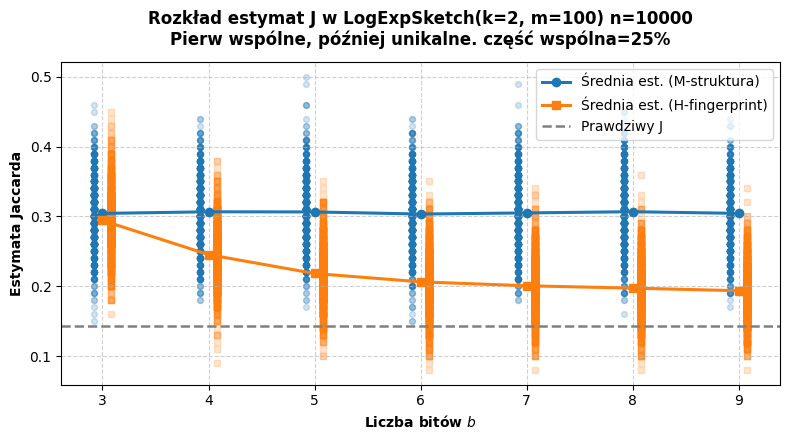

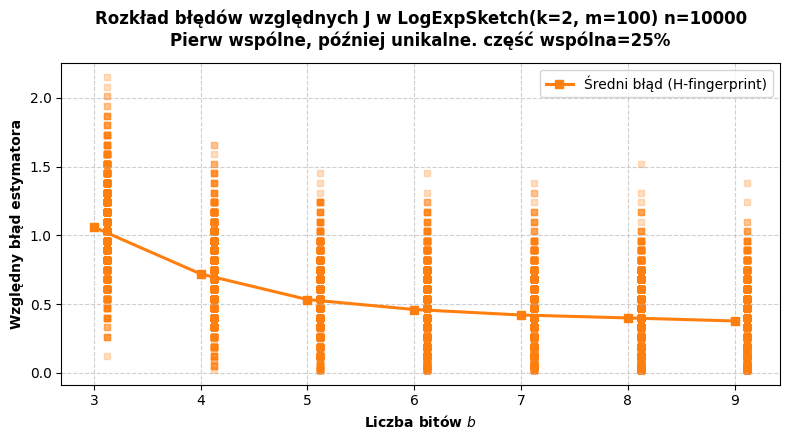

In [57]:
opis_testu="Pierw wspólne, później unikalne. część wspólna=25%"
make_estimate_plot(b_vals, all_js, all_jf, est_s_mean, est_f_mean, f"LogExpSketch(k={k}, m={m}) n={n}", trials, true_J, opis_testu)
make_relative_error_plot(b_vals, all_err_s, all_err_f, trials, err_s_mean, err_f_mean, False, f"LogExpSketch(k={k}, m={m}) n={n}", opis_testu)

In [58]:
import numpy as np, math

# --- parametry -----------------------------------------------------------
m, n, overlap = 100, 10_00, 250
true_J  = overlap / (2*n - overlap)
b_vals  = range(3, 10)
trials  = 1000
pool    = 2_000_000
rng     = np.random.default_rng()
k, bits_per_field = 2, 8

# --- pojemniki -----------------------------------------------------------
est_s_mean, est_f_mean = [], []
err_s_mean, err_f_mean = [], []

all_js, all_jf   = [], []   # chmura estymat
all_err_s, all_err_f = [], []   # chmura błędów względnych

for b in b_vals:
    js, jf   = [], []
    errs_s, errs_f = [], []

    for _ in range(trials):
        seeds = generate_seeds(m)
        A = ExpSketch(m, b, seeds)
        B = ExpSketch(m, b, seeds)

        shared  = rng.choice(pool, overlap,      False)
        uniq_a  = rng.choice(pool, n - overlap,  False)
        uniq_b  = rng.choice(pool, n - overlap,  False)

        stream_A = np.concatenate([shared, uniq_a])
        stream_B = np.concatenate([shared, uniq_b])
        rng.shuffle(stream_A); rng.shuffle(stream_B)

        for x in stream_A: A.add(f"s{x}" if x in shared else f"a{x}")
        for x in stream_B: B.add(f"s{x}" if x in shared else f"b{x}")

        est_s = A.jaccard_struct(B)
        est_f = A.jaccard_fp(B)

        js.append(est_s); jf.append(est_f)

        err_s = abs(est_s - true_J) / true_J
        err_f = abs(est_f - true_J) / true_J
        errs_s.append(err_s); errs_f.append(err_f)

    # --- odkładamy „chmury” ----------------------------------------------
    all_js.append(js);           all_jf.append(jf)
    all_err_s.append(errs_s);    all_err_f.append(errs_f)

    # --- średnie ---------------------------------------------------------
    est_s_mean.append(np.mean(js));  est_f_mean.append(np.mean(jf))
    err_s_mean.append(np.mean(errs_s)); err_f_mean.append(np.mean(errs_f))


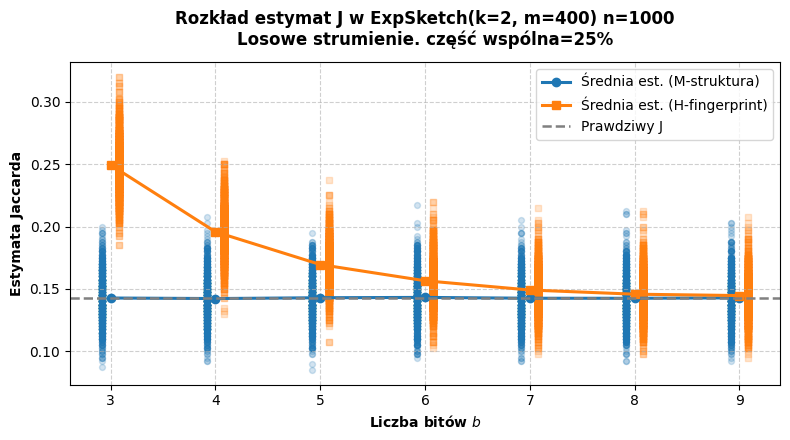

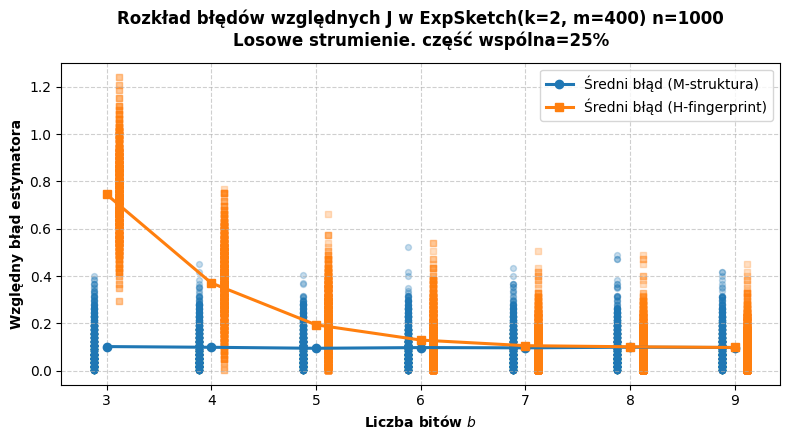

In [62]:
opis_testu="Losowe strumienie. część wspólna=25%"
make_estimate_plot(b_vals, all_js, all_jf, est_s_mean, est_f_mean, f"ExpSketch(k={k}, m={m}) n={n}", trials, true_J, opis_testu)
make_relative_error_plot(b_vals, all_err_s, all_err_f, trials, err_s_mean, err_f_mean, True, f"ExpSketch(k={k}, m={m}) n={n}", opis_testu)

In [60]:
import numpy as np, math

# --- parametry -----------------------------------------------------------
m, n, overlap = 400, 10_00, 250
true_J  = overlap / (2*n - overlap)
b_vals  = range(3, 10)
trials  = 1000
pool    = 2_000_000
rng     = np.random.default_rng()
k, bits_per_field = 2, 8

# --- pojemniki -----------------------------------------------------------
est_s_mean, est_f_mean = [], []
err_s_mean, err_f_mean = [], []

all_js, all_jf   = [], []   # chmura estymat
all_err_s, all_err_f = [], []   # chmura błędów względnych

for b in b_vals:
    js, jf   = [], []
    errs_s, errs_f = [], []

    for _ in range(trials):
        seeds = generate_seeds(m)
        A = ExpSketch(m, b, seeds)
        B = ExpSketch(m, b, seeds)

        shared  = rng.choice(pool, overlap,      False)
        uniq_a  = rng.choice(pool, n - overlap,  False)
        uniq_b  = rng.choice(pool, n - overlap,  False)

        stream_A = np.concatenate([shared, uniq_a])
        stream_B = np.concatenate([shared, uniq_b])
        rng.shuffle(stream_A); rng.shuffle(stream_B)

        for x in stream_A: A.add(f"s{x}" if x in shared else f"a{x}")
        for x in stream_B: B.add(f"s{x}" if x in shared else f"b{x}")

        est_s = A.jaccard_struct(B)
        est_f = A.jaccard_fp(B)

        js.append(est_s); jf.append(est_f)

        err_s = abs(est_s - true_J) / true_J
        err_f = abs(est_f - true_J) / true_J
        errs_s.append(err_s); errs_f.append(err_f)

    # --- odkładamy „chmury” ----------------------------------------------
    all_js.append(js);           all_jf.append(jf)
    all_err_s.append(errs_s);    all_err_f.append(errs_f)

    # --- średnie ---------------------------------------------------------
    est_s_mean.append(np.mean(js));  est_f_mean.append(np.mean(jf))
    err_s_mean.append(np.mean(errs_s)); err_f_mean.append(np.mean(errs_f))


/tmp/ipykernel_6399/4103805796.py:31: RuntimeWarning: divide by zero encountered in log
  g = -np.log(u) / weight


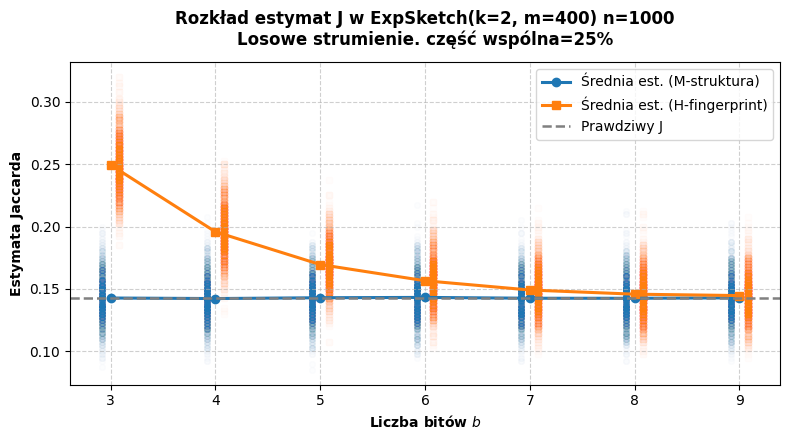

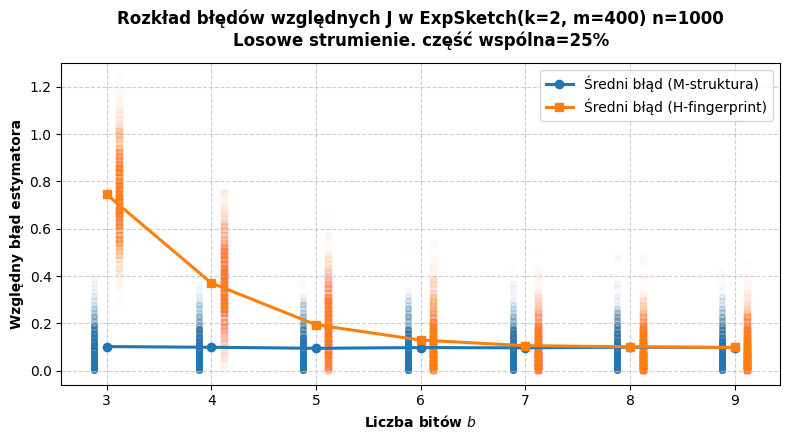

In [68]:
opis_testu="Losowe strumienie. część wspólna=25%"
make_estimate_plot(b_vals, all_js, all_jf, est_s_mean, est_f_mean, f"ExpSketch(k={k}, m={m}) n={n}", trials, true_J, opis_testu)
make_relative_error_plot(b_vals, all_err_s, all_err_f, trials, err_s_mean, err_f_mean, True, f"ExpSketch(k={k}, m={m}) n={n}", opis_testu)